## ResNet

<img src=attachment:image.png width=500>
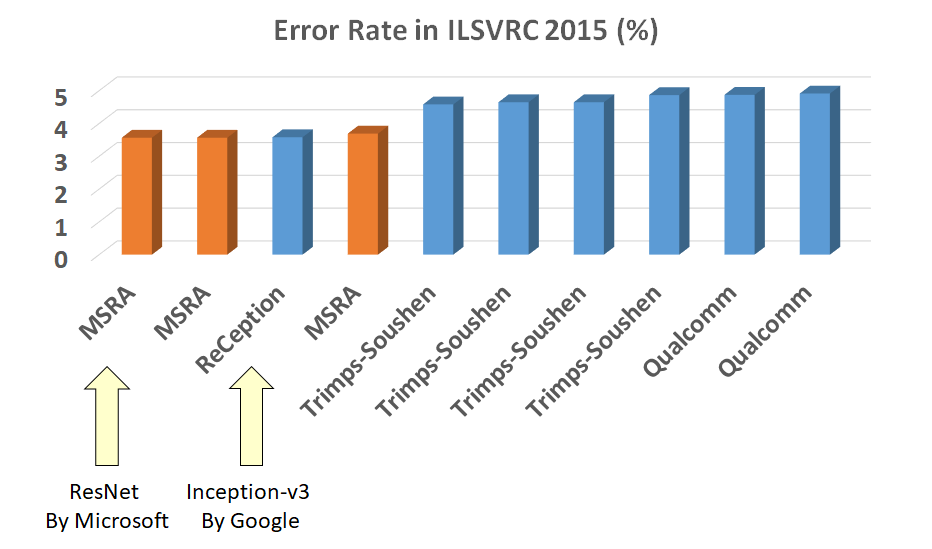

<img src=attachment:image.png width=500><center>*source: https://arxiv.org/pdf/1512.03385.pdf</center>
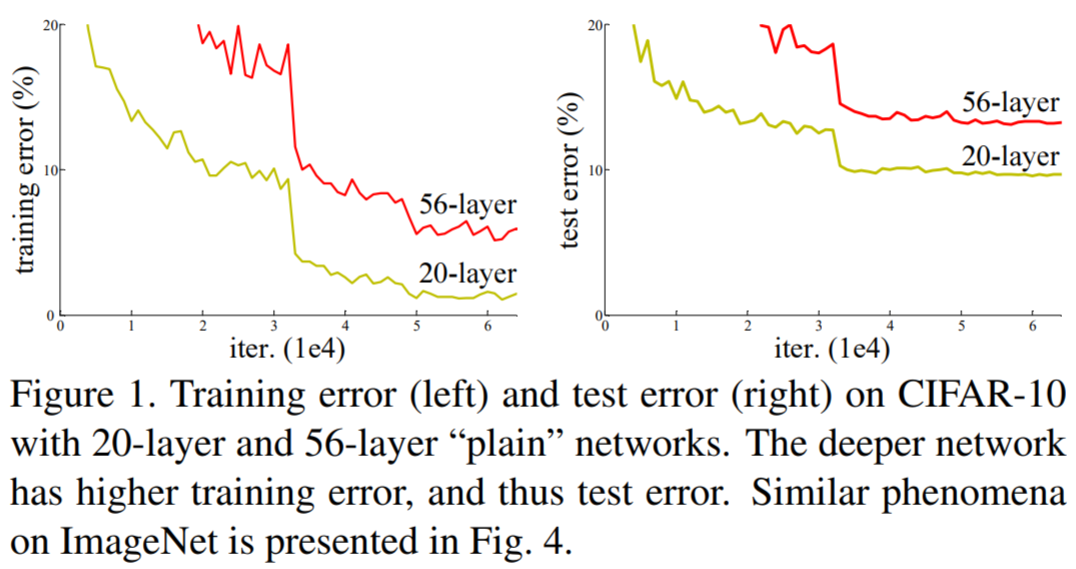

- Deeper한 구조를 만들고 싶지만, plain하게 계속 쌓을 경우 학습이 어려워 오히려 성능 저하 발생

<img src=attachment:image.png width=500><center>*source: https://arxiv.org/pdf/1512.03385.pdf</center>
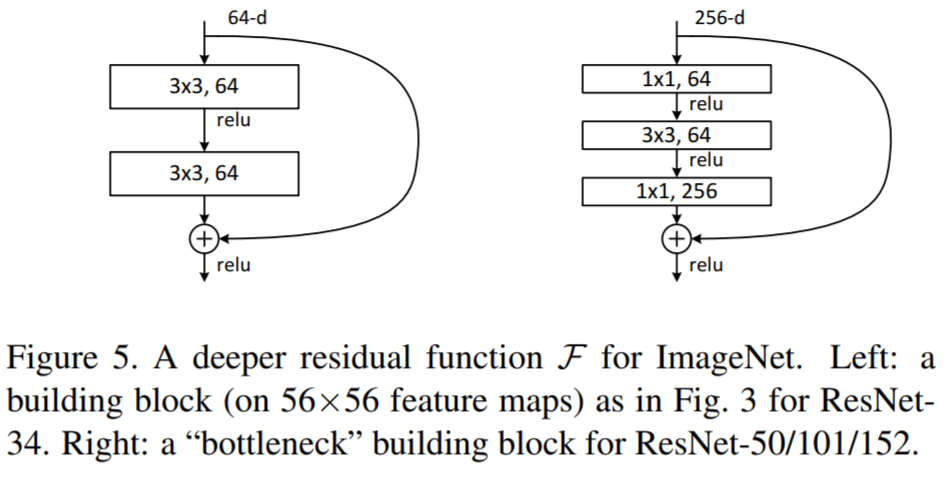

- Skip connection을 이용해 깊게 쌓을 수 있도록 한다. 
- 위 그림은 ResNet의 기본적인 Block 두가지. 'Basic block', 'Bottleneck block' 
- Identity x를 더해주기 위해 Block을 통과해도 [Depth, H, W]를 계속 유지하기 위한 Trick.

<img src=attachment:image.png width=800>
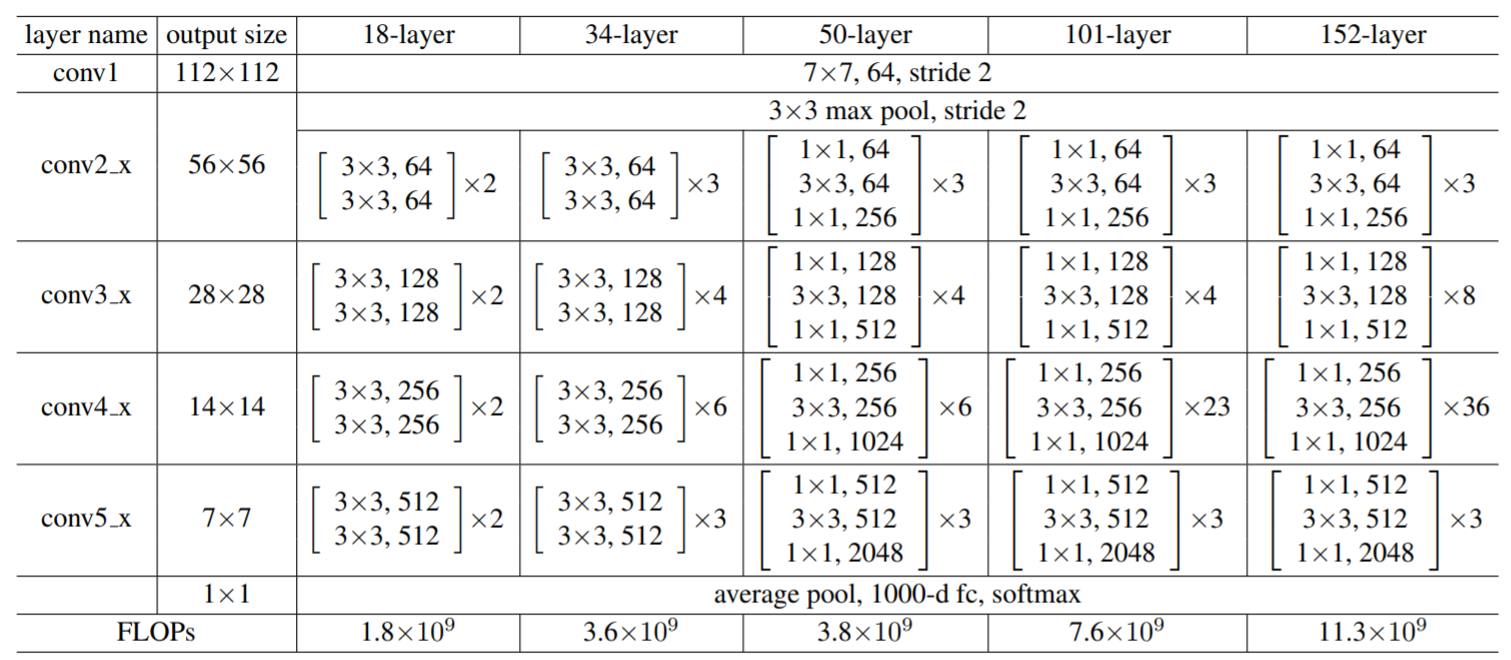

- Downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2.
- 각 conv layer의 첫번째 blokc에서 3x3, stride=2로 H, W 절반으로 축소하는 역할
- ResNet50 = conv1 + 마지막 fc1 + 3-layer짜리  Bottleneck block이 3*(3+4+6+3) = 48 = 총 50개 layer
    - ResNet18, ResNet34까지는 Basic block으로 Building. 그 이후는 Bottleneck block으로 building

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0")

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.conv1(x) # 3x3 stride = 2
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = 1
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)  #만약 stride=2로 인해 H,W가 downsample 되었다면 identity x도 downsample

        out += identity  #이렇게 out과 identity의 차원을 맞춰져서 element-wise로 잘 더해질 수 있게.
        out = self.relu(out)

        return out

In [4]:
class Bottleneck(nn.Module):  #마찬가지로 Bottleneck 구조
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) #conv1x1(64,64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)#conv3x3(64,64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64,256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride 
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

- torchvision.models로 확인해보자

In [5]:
import torchvision.models.resnet as resnet

In [6]:
res50 = resnet.resnet50()   # conv1 + Bottleneck block [3,4,6,3]개 + fc1 

In [7]:
res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

- 1x1 conv는 전체 모델의 complexity를 낮춰주면서 성능 degradation은 거의 없도록 해주는 역할
- Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

## CIFAR10 Training

In [8]:
# MNIST dataset
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

Files already downloaded and verified


- Normalizing dataset

In [9]:
train_mean = cifar_train.data.mean(axis=(0,1,2))
train_std = cifar_train.data.std(axis=(0,1,2))

In [10]:
print(train_mean)
print(train_std)

[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]


In [11]:
train_mean = train_mean/255
train_std = train_std/255

In [12]:
print(train_mean)
print(train_std)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [13]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [14]:
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transform_train,
                          download=True)

cifar_test = datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=transform_test,
                         download=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
epochs = 40
batch_size = 128

valid_ratio = 0.1

In [16]:
num_train = len(cifar_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_ratio * num_train))

In [17]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=train_sampler,
                                          drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=valid_sampler,
                                          drop_last=True)

In [19]:
def vaild_loss(model_valid):
    avg_loss = 0
    with torch.no_grad():
        model_valid.eval()
        for images, labels in valid_loader:
            pred = model_valid(images.to(device))
            criterion = nn.CrossEntropyLoss().to(device)
            loss = criterion(pred, labels.to(device))
            avg_loss+= loss.item()
    
    return avg_loss / len(valid_loader)

In [20]:
xx = torch.Tensor(10,3,32,32)
output = res50(xx)
print(output.shape)

torch.Size([10, 1000])


- ImageNet 대상 모델이라 마지막 output이 1000이네. 나에게 맞게 customize 하는 방법?
- github.com/pytorch 에 코드 공개되어 있으니, resnet.py를 그대로 복붙해서 local에 파일 만들고 원하는대로 수정하고 import 하면됨

- ResNet에서는 Global Average Pooling 사용.
- In the last few years, experts have turned to global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.



In [21]:
from models import myresnet

In [22]:
net = myresnet.resnet50()
out = net(xx)
print(out.shape)

torch.Size([10, 10])


In [23]:
model = myresnet.resnet50().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.80)

In [24]:
total_batch = len(train_loader)
model.train()
best_valid = np.inf

for epoch in range(epochs):
    avg_loss = 0
    lr_schedule.step()

    for itr, data in enumerate(train_loader):
        X,Y = data
        X = X.to(device) #img
        Y = Y.to(device) #label

        pred = model(X)
        loss = criterion(pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch
    
    loss_valid = vaild_loss(model)
    print('Epoch:{}, train loss:{:.5f}, valid loss:{:.5f}'.format(epoch, avg_loss, loss_valid))

    if loss_valid < best_valid:
        torch.save(model.state_dict(), './saves/models/resnet_cifar10.pth')
        best_valid = loss_valid

Epoch:0, train loss:1.60388, valid loss:1.42893
Epoch:1, train loss:1.98961, valid loss:1.71648
Epoch:2, train loss:1.60111, valid loss:1.61364
Epoch:3, train loss:1.46500, valid loss:1.36654
Epoch:4, train loss:1.35605, valid loss:1.46031
Epoch:5, train loss:1.23535, valid loss:1.22089
Epoch:6, train loss:1.16821, valid loss:1.12414
Epoch:7, train loss:1.10589, valid loss:1.13725
Epoch:8, train loss:1.02274, valid loss:1.05613
Epoch:9, train loss:0.98613, valid loss:0.96940
Epoch:10, train loss:0.93431, valid loss:0.94829
Epoch:11, train loss:0.88102, valid loss:0.91083
Epoch:12, train loss:0.84151, valid loss:0.89715
Epoch:13, train loss:0.81642, valid loss:0.88934
Epoch:14, train loss:0.76224, valid loss:0.82469
Epoch:15, train loss:0.74442, valid loss:0.83549
Epoch:16, train loss:0.71272, valid loss:0.81095
Epoch:17, train loss:0.66800, valid loss:0.78383
Epoch:18, train loss:0.65296, valid loss:0.81668
Epoch:19, train loss:0.63056, valid loss:0.76057
Epoch:20, train loss:0.59001, 

In [25]:
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=256, shuffle=False)

In [26]:
correct = 0
total = 0
model_test = myresnet.resnet50().to(device)
model_test.load_state_dict(torch.load('./saves/models/resnet_cifar10.pth'))

with torch.no_grad():
    model_test.eval()
    for images, labels in test_loader:
        output = model_test(images.to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('Accuracy on test images with ResNet:', (correct / total))

Accuracy on test images with ResNet: 0.7667
